In [1]:
import importlib
import ZGN_PDE 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid

import pysindy as ps
import timeit
import os
from shutil import rmtree

from IPython.display import Video

# Seed the random number generators for reproducibility
np.random.seed(100)

## Import and smooth histograms 

In [2]:
filebase='data/ensemble/1'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H,dmax=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
t=np.arange(0,t1+dt,dt)
#dat=np.transpose(np.load('data/ensemble/smoothhistograms.npy'),axes=(2,1,0))
dat=np.transpose(np.load('data/ensemble/histograms.npy'),axes=(2,1,0))
nx,ny,nt=dat.shape
vmax=25
X, Y = np.meshgrid(np.arange(0,L,L/nx),np.arange(-vmax,vmax,2*vmax/ny),indexing="ij")
spatial_grid = np.transpose(np.asarray([X, Y]),axes=(1,2,0))

In [3]:
sigmax=10
sigmay=10
sigmat=10

kernelx=np.roll(np.exp(-(np.arange(nx)-nx/2)**2/(2*sigmax**2))/(2*np.pi*(sigmax/nx)**2)**0.5/nx,int(nx/2))
kernely=np.roll(np.exp(-(np.arange(ny)-ny/2)**2/(2*sigmay**2))/(2*np.pi*(sigmay/ny)**2)**0.5/ny,int(ny/2))
kernelt=np.roll(np.exp(-(np.arange(nt)-nt/2)**2/(2*sigmat**2))/(2*np.pi*(sigmat/nt)**2)**0.5/nt,int(nt/2))
kernel=np.einsum('i,j,k->ijk',kernelx,kernely,kernelt)
kernel.shape
dat2=np.real(np.fft.ifftn(kernel*np.fft.fftn(dat)))

## Derivatives

In [4]:
start=timeit.default_timer()
tpad=50
nx,ny,nt=dat2.shape
nt=nt-2*tpad
t=t[tpad:-tpad]-t[tpad]

U=np.zeros((nx,ny,nt,3))
U_dot=np.zeros((nx,ny,nt,3))

U[:,:,:,0]=np.transpose(dat2[:,:,tpad:-tpad]*np.sum(dat[:,:,0])/np.sum(dat2[:,:,0]),axes=(1,0,2))
U[:,:,:,1]=np.transpose(spatial_grid[:,:,1][:,:,np.newaxis],axes=(0,1,2))
U[:,:,:,2]=np.transpose(spatial_grid[:,:,0][:,:,np.newaxis],axes=(0,1,2))
print(U.shape)

for i in range(nx):
    for j in range(ny):
        print(i,j,end='\r')
        U_dot[i, j, :, :] = ps.FiniteDifference()._differentiate(U[i, j, :, :], dt)

U_flat = np.reshape(U, (nx*ny*nt, 3))
U_dot_flat = np.reshape(U, (nx*ny*nt, 3))

stop=timeit.default_timer()
print(stop-start)

(100, 100, 901, 3)
5.06609005498467


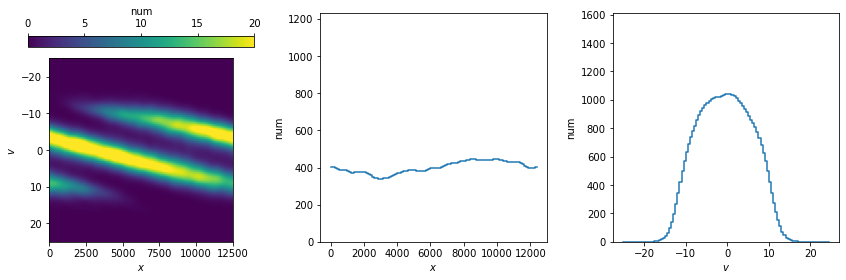

In [5]:
smoothhistograms=np.transpose(U[:,:,:,0],(2,0,1))
nmax=np.max(smoothhistograms)
nmaxv=np.max(np.sum(smoothhistograms,axis=1))
nmaxx=np.max(np.sum(smoothhistograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(smoothhistograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(smoothhistograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(smoothhistograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

## pysindy with smoothed derivatives

In [6]:
library_functions = [lambda x: x, lambda x: x * x ]
library_function_names = [lambda x: x, lambda x: x + '^2']
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, spatial_grid=spatial_grid,
                        temporal_grid=t, include_bias=True, 
                        is_uniform=True, weak_form=False)

U_flat = np.reshape(U, (nx*ny*nt, 3))

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-3, normalize_columns=False, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['u','p'])

In [7]:
start=timeit.default_timer()
model.fit(np.array([U_flat[:,0],U_flat[:,1]]).T)
model.print()
stop=timeit.default_timer()
print(stop-start)

/home/zackn/manybody/pysindy/optimizers/stlsq.py:174: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


(u)' = -0.210 u_1 + -0.922 up_1
(p)' = 0.000
18.622888729994884


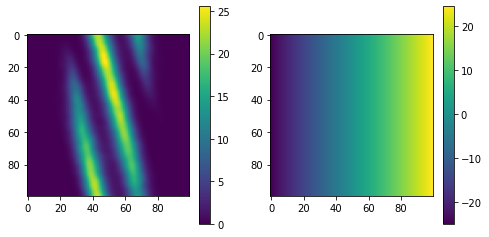

In [8]:
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.reshape(U_flat[:,0],(nx,ny,nt))[:,:,-1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.reshape(U_flat[:,1],(nx,ny,nt))[:,:,-1])
plt.colorbar()
plt.show()


##  Weak-form sindy

In [9]:
K=50
Hx=L/20
Hy=vmax/20
Ht=10
library_functions = [lambda x: x, lambda x: x * x ]
library_function_names = [lambda x: x, lambda x: x + '^2']
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, spatial_grid=spatial_grid,
                        temporal_grid=t, include_bias=True, K=K, Hx=Hx, Hy=Hy, Ht=Ht,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)

In [10]:
# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_2D(u, t, pde_lib):  # For weak form 2D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0], 
                                            pde_lib.spatial_grid[0, :, 1],
                                            t), 
                                           u[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :])
            XYt = np.array((X, Y, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, 
                            x=pde_lib.xgrid_k[k, :], 
                            axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

In [11]:
U_dot_integral = convert_u_dot_2D(U, t, pde_lib)
U_flat = np.reshape(U, (nx*ny*nt, 3))

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-3, normalize_columns=False, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['u','p'])

In [12]:
#Fit with the momentum but no position
start=timeit.default_timer()
model.fit(U_flat[:,:2], x_dot=U_dot_integral[:,:2])
model.print()
stop=timeit.default_timer()
print(stop-start)

(u)' = -0.143 u_1 + -0.853 up_1
(p)' = 0.000
51.725565775996074


/home/zackn/manybody/pysindy/optimizers/stlsq.py:174: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/zackn/manybody/pysindy/optimizers/stlsq.py:174: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


##  Integrate collisionless Boltzmann with pseudospectral

In [13]:
u0=U[:,:,0,0]

def dudt(t, u, x, p):
    nx=len(x)
    ny=len(p)
    ux = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=1) 
    up = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),2*vmax/ny,axis=1,order=1) 
    return np.reshape(-p*np.real(ux),(nx*ny))

mmax=len(t)-1
tmax=t[mmax]
dt=t[1]-t[0]
start=timeit.default_timer()
sol=solve_ivp(dudt,[0,tmax],np.reshape(u0,(nx*ny)), method='LSODA', args=[np.arange(0,L,L/nx),np.arange(-vmax,vmax,2*vmax/ny)], t_eval=t[:mmax+1],rtol=1e-8,atol=1e-8)
stop=timeit.default_timer()
print(stop-start)

1.7777039369975682


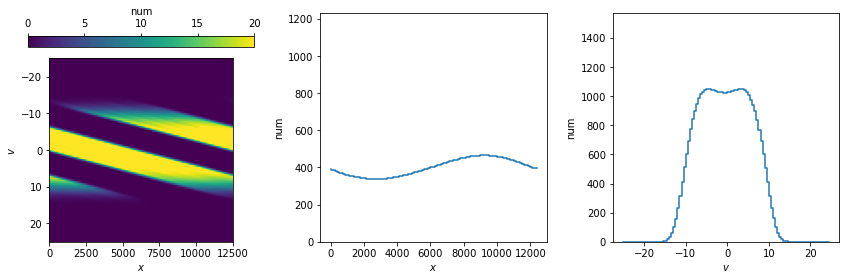

In [14]:
histograms=np.transpose(np.reshape(sol.y,(nx,ny,mmax+1)),(2,0,1))
nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(histograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(histograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(histograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

##  Sam's PDE_find with Zack's optimizations

In [22]:
Ux=np.zeros((nx,ny,nt,1))
Uxx=np.zeros((nx,ny,nt,1))
Up=np.zeros((nx,ny,nt,1))

for k in range(nt):
    for j in range(ny):
        print(k,j,end=' \r')
        Ux[:, j, k, :] = ps.FiniteDifference()._differentiate(U[:, j, k, :1], L/nx)
        Uxx[:, j, k, :] = ps.FiniteDifference(d=2)._differentiate(U[:, j, k, :1], L/nx)
        
    for i in range(nx):
        print(k,j,end=' \r')
        Up[i, :, k, :] = ps.FiniteDifference()._differentiate(U[i, :, k, :1], 2*vmax/ny)

In [74]:
start=timeit.default_timer()

importlib.reload(ZGN_PDE)
#We don't need the last axis in the features here...
features = np.hstack([np.reshape(U[:,:,:,:1], (nx*ny*nt,1)),
                      np.reshape(U[:,:,:,1:2], (nx*ny*nt,1)),
                      np.reshape(UX,(nx*ny*nt,1)),
                      np.reshape(UXX,(nx*ny*nt,1)),
                      np.reshape(UP,(nx*ny*nt,1)),
                      np.reshape(UPP,(nx*ny*nt,1))])

X, descr = ZGN_PDE.build_Theta2(features, 2, feature_descriptions = ['u','p','u_x','u_xx','u_p','u_pp'])
stop=timeit.default_timer()
print(stop-start)

34.89657544301008


In [42]:
start=timeit.default_timer()
X_ders = np.hstack([np.ones((nx*ny*nt,1)),np.reshape(UX,(nx*ny*nt,1)),np.reshape(UXX,(nx*ny*nt,1)),np.reshape(UP,(nx*ny*nt,1)),np.reshape(UPP,(nx*ny*nt,1))])
X_data = np.hstack([np.reshape(U[:,:,:,:1], (nx*ny*nt,1)),np.reshape(U[:,:,:,1:2], (nx*ny*nt,1))])
derivatives_description = ['','u_{x}','u_{xx}','u_{p}','u_{pp}']
X, descr = ZGN_PDE.build_Theta(X_data, X_ders, derivatives_description, 3, data_description = ['u','p'])
stop=timeit.default_timer()
print(stop-start)

65.47546714899363


In [75]:
w=ZGN_PDE.STRidge(X, np.reshape(U_dot[:,:,:,:1],(nx*ny*nt,1)), 1e-2, 10, 0.1, normalize = 0, print_results = True)
ZGN_PDE.print_pde(w,descr)

iter, terms: 0 28
iter, terms: 1 9
iter, terms: 2 8
u_t = (284.493736 +0.000000i)u_xx
    + (11.034406 +0.000000i)u_xxu_pp
    + (-2.063938 +0.000000i)u_xxu_p
    + (-0.231183 +0.000000i)u_x
    + (-27.797892 +0.000000i)u_x^2
    + (0.588023 +0.000000i)pu_xx
    + (-0.956485 +0.000000i)pu_x
    + (-4.798294 +0.000000i)uu_xx
   


## integrate sindy model with pseudospectral

In [37]:
coeffs=np.real(w[np.nonzero(np.real(w))[0]])
u0=U[:,:,0,0]

def dudt(t, u, x, p):
    nx=len(x)
    ny=len(p)
    ux = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=1) 
    uxx = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=2) 
    return np.reshape((coeffs[0]+coeffs[1]*p)*np.real(ux)+(coeffs[2]*p**2+coeffs[3]*u.reshape((nx,ny))*p+coeffs[4]*u.reshape((nx,ny))**2)*np.real(uxx),(nx*ny))

mmax=len(t)-1
tmax=t[mmax]
dt=t[1]-t[0]
start=timeit.default_timer()
bsol=solve_ivp(dudt,[0,tmax],np.reshape(u0,(nx*ny)), method='BDF', args=[np.arange(0,L,L/nx),np.arange(-vmax,vmax,2*vmax/ny)], t_eval=t[:mmax+1],rtol=1e-8,atol=1e-8)
stop=timeit.default_timer()
print(stop-start)

192.53007688300568


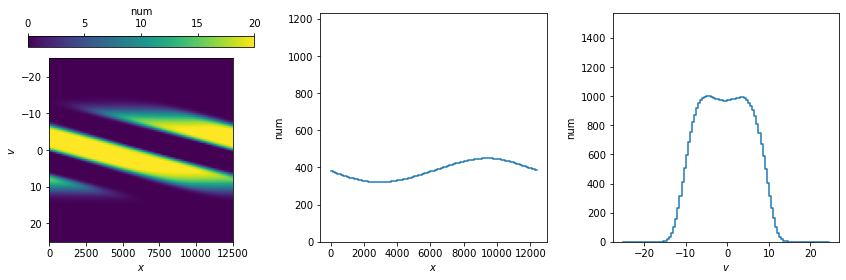

In [38]:
bhistograms=np.transpose(np.reshape(bsol.y,(nx,ny,mmax+1)),(2,0,1))
nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(bhistograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(bhistograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(bhistograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

## Compare results

In [20]:
filebase='data/sindyfit'
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
start=timeit.default_timer()
for i in range(0,len(t),skip):
    print(i, len(t),end='\r')
    plt.subplots(3,3,figsize=(10,10))
    plt.subplot(3,3,1)
    plt.imshow(smoothhistograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,2)
    plt.step(np.arange(0,L,L/nx),np.sum(smoothhistograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,3)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(smoothhistograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    
    plt.subplot(3,3,4)
    plt.imshow(histograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,5)
    plt.step(np.arange(0,L,L/nx),np.sum(histograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,6)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(histograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    
    plt.subplot(3,3,7)
    plt.imshow(bhistograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,8)
    plt.step(np.arange(0,L,L/nx),np.sum(bhistograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,9)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(bhistograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    plt.tight_layout()
    plt.savefig(filebase+'animation/'+str(int(i/skip)).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 30 ')
rmtree(filebase+'animation')

stop=timeit.default_timer()
print(stop-start)

1099.970664018765


In [21]:
filebase='data/sindyfit'

Video(filebase+'animation.mp4',width=800)